# Parallel Computing for 94-class Character Recognition Using Convolutional Neural Networks

This notebook explores the "94 character TMNIST" dataset, which contains images of various characters (letters, numbers, and symbols) across different font styles. We'll perform analysis of the dataset's structure and demonstrate how to balance class distribution, which is important for training effective machine learning models.

## Loading and Examining the Dataset

In [1]:
import time
import numpy as np
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [2]:
# Read the CSV into a DataFrame
df = pd.read_csv("../Data/94_character_TMNIST.csv")

# Display the first few rows
df.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The output shows the first 5 rows of our dataset. We can see that each row represents a character image with the following columns:

- names: Font name/style used
- labels: The actual character (letter, number, or symbol)
- Columns numbered 1 through 784: These represent the pixel values of the 28×28 images (784 pixels total) in a flattened format

Let's examine the dataset's overall shape to understand how many samples we have.

In [3]:
# Get dataset dimensions
print("Data shape:", df.shape)

Data shape: (274093, 786)


The dataset has 274,093 rows (samples) and 786 columns. There are 784 pixel columns plus the 'names' and 'labels' columns.

Let's get more information about the dataset's structure:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274093 entries, 0 to 274092
Columns: 786 entries, names to 784
dtypes: float64(784), object(2)
memory usage: 1.6+ GB


This output gives us more details about the dataset. The pixel values are stored as float64 type, and we can see that the dataset is quite large, taking up about 1.6+ GB of memory.

In [5]:
# Get label counts and unique values
label_counts = df['labels'].value_counts()
unique_labels = df['labels'].nunique()

print(f"Total unique labels: {unique_labels}")
print(f"Label distribution:\n{label_counts}")

Total unique labels: 94
Label distribution:
labels
6    2990
2    2990
7    2990
5    2990
4    2990
     ... 
E    2874
g    2874
V    2874
b    2874
`    2848
Name: count, Length: 94, dtype: int64


We have 94 unique character classes in our dataset. The output shows that the distribution is imbalanced, with some characters having more samples than others. This imbalance could affect model training, as the model might become biased towards overrepresented classes.

## Understanding What's in the Dataset

Let's visualize some examples from the dataset to better understand what we're working with:

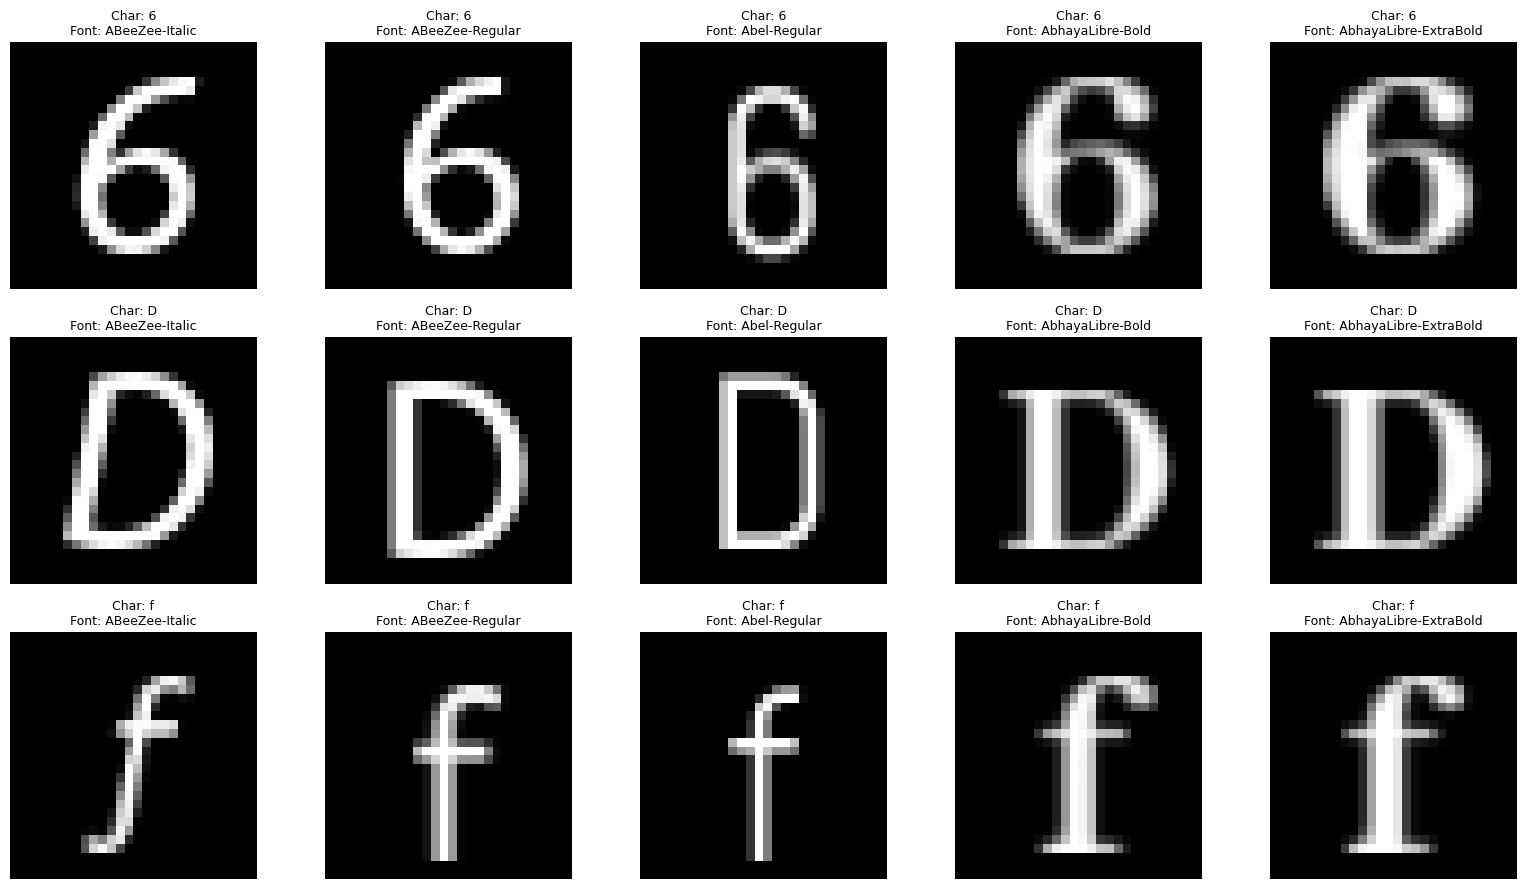

In [6]:
# Choose a few labels to visualize
selected_labels = df['labels'].unique()[:3]  # Pick first 3 unique labels for demo

# Set up the figure
fig, axes = plt.subplots(len(selected_labels), 5, figsize=(16, 3 * len(selected_labels)))
axes = axes.reshape(len(selected_labels), 5)

for i, label in enumerate(selected_labels):
    # Filter rows with current label
    label_df = df[df['labels'] == label]
    sampled = label_df.groupby('names')[label_df.columns].apply(lambda x: x.sample(1)).reset_index(drop=True).head(5)
    for j in range(5):
        if j < len(sampled):
            row = sampled.iloc[j]
            pixels = row.drop(['names', 'labels']).values.astype(np.float32).reshape(28, 28)
            axes[i, j].imshow(pixels, cmap='gray')
            axes[i, j].set_title(f"Char: {label}\nFont: {row['names']}", fontsize=9)
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')  # hide unused plots

plt.tight_layout()
plt.show()

This visualization shows examples of characters from the first three unique labels in our dataset. For each character, we display 5 different font styles. This helps us understand the variation within each character class.

Let's visualize this distribution:

Total unique labels: 94
Label distribution:
labels
6    2990
2    2990
7    2990
5    2990
4    2990
     ... 
E    2874
g    2874
V    2874
b    2874
`    2848
Name: count, Length: 94, dtype: int64


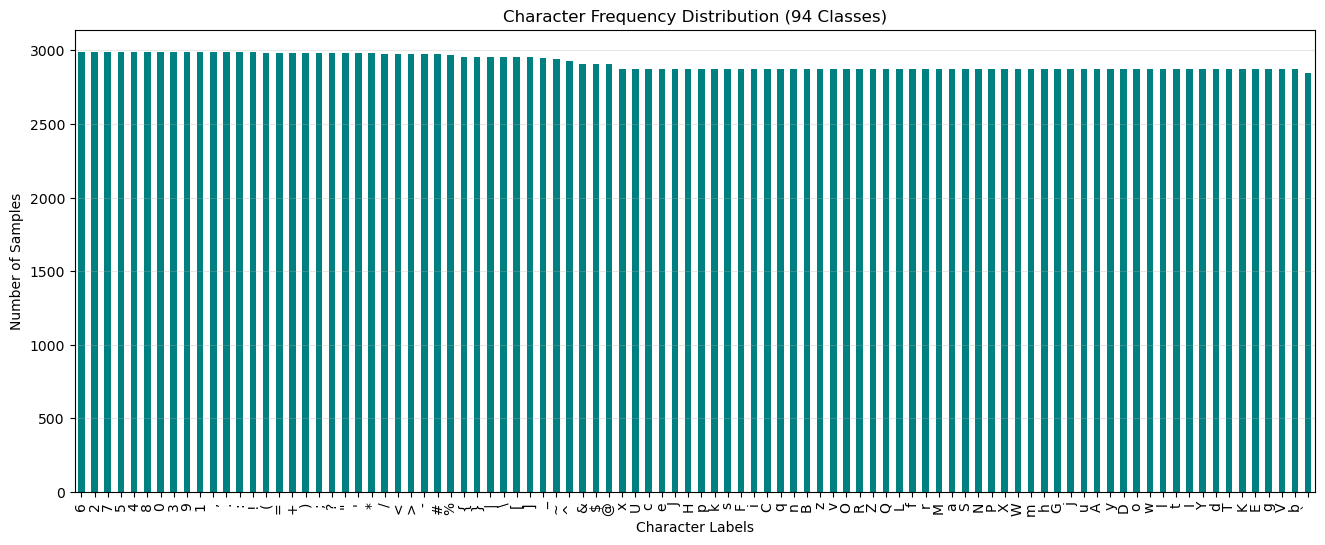

In [7]:
# Get label counts and unique values
label_counts = df['labels'].value_counts()
unique_labels = df['labels'].nunique()

print(f"Total unique labels: {unique_labels}")
print(f"Label distribution:\n{label_counts}")

plt.figure(figsize=(16, 6))
label_counts.plot(kind='bar', color='teal')
plt.title("Character Frequency Distribution (94 Classes)")
plt.xlabel("Character Labels")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.show()

The bar chart confirms that we have an imbalanced dataset. Some characters have nearly 3,000 samples while others have fewer. This imbalance can lead to poor performance on underrepresented classes when training machine learning models.

This detailed view confirms that we have 94 unique characters, with varying numbers of samples for each. Some characters have as many as 2,990 samples, while others have as few as 2,848. While this isn't an extreme imbalance, balancing the dataset will still be beneficial for training.

## Balancing the Dataset with Multiprocessing

Let's now balance the dataset by ensuring each class has the same number of samples. We'll use multiprocessing to speed up this operation:

**Step 1: Preparing the Data for Parallel Processing:**

First, we split the dataset into groups by character label. Then we find the smallest group size, which will determine how many samples we take from each class to ensure balance.

**Step 2: Creating the Sampling Function:**

This function takes a label, a DataFrame containing samples of that label, and a number of samples to return. It randomly selects n samples from the group. The random_state=42 parameter ensures reproducibility of our sampling.

**Step 3: Preparing Arguments for Parallel Processing:**

For each character class, we create a tuple containing the label, the corresponding DataFrame, and the number of samples to take. These tuples will be passed to our sampling function in parallel.

**Step 4: Parallel Processing with starmap:**

Python's multiprocessing.Pool creates a pool of worker processes.

**Step 5: Measuring Performance Across Different CPU Counts:**

We test the processing time with 2, 4, 6, and 8 CPU cores to find the optimal configuration for our system. For each configuration, we:

**Step 6: Analyzing Parallel Processing Efficiency:**

We calculate two important metrics:

Speedup: How much faster the process is with multiple cores compared to our baseline (2 cores)
Efficiency: How effectively we're using the additional cores (speedup divided by core count)

**Step 7: Visualizing the Performance Results:**

The three plots show:

- Wall-Clock Time: The actual time it took to process the data with different numbers of cores

- Speedup: How many times faster the operation became with more cores

- Efficiency: How well we utilized the additional computing resources

2 CPU(s): 8.9644 seconds
4 CPU(s): 6.9915 seconds
6 CPU(s): 7.8936 seconds
8 CPU(s): 7.8694 seconds


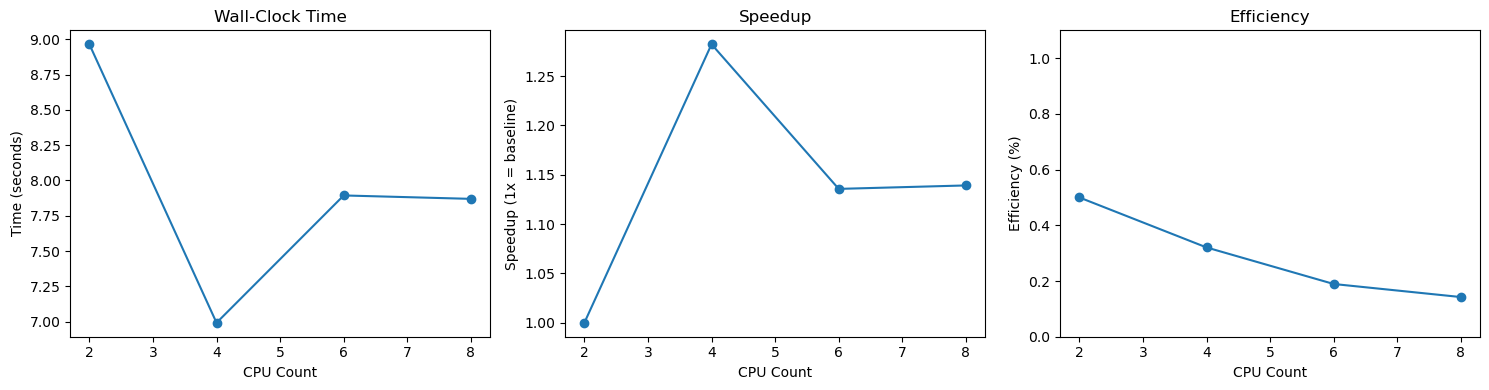

In [8]:
groups = list(df.groupby('labels'))
min_class_count = min(len(g) for _, g in groups)

# Function to sample from each group
def sample_group(label, group_df, n):
    return group_df.sample(n=n, random_state=42)

# Create args for starmap
args = [(label, group, min_class_count) for label, group in groups]

# Benchmarking
cpu_counts = [2, 4, 6, 8]
timings = []

for cpus in cpu_counts:
    start = time.perf_counter()
    with Pool(processes=cpus) as pool:
        results = pool.starmap(sample_group, args)
    elapsed = time.perf_counter() - start
    timings.append(elapsed)
    print(f"{cpus} CPU(s): {elapsed:.4f} seconds")

# Compute speedup and efficiency
base_time = timings[0]
speedups = [base_time / t for t in timings]
efficiencies = [s / c for s, c in zip(speedups, cpu_counts)]

# Plotting
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(cpu_counts, timings, marker='o')
plt.title("Wall-Clock Time")
plt.xlabel("CPU Count")
plt.ylabel("Time (seconds)")

plt.subplot(1, 3, 2)
plt.plot(cpu_counts, speedups, marker='o')
plt.title("Speedup")
plt.xlabel("CPU Count")
plt.ylabel("Speedup (1x = baseline)")

plt.subplot(1, 3, 3)
plt.plot(cpu_counts, efficiencies, marker='o')
plt.title("Efficiency")
plt.xlabel("CPU Count")
plt.ylabel("Efficiency (%)")
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

This section demonstrates how using multiple CPU cores can speed up data processing. I'm sampling an equal number of examples from each character class, and timing how long it takes with different numbers of CPU cores. The three plots show:

1. Wall-Clock Time: The actual time it took to process the data
2. Speedup: How much faster the operation is relative to using just 2 CPUs
3. Efficiency: How well we're utilizing the additional CPU cores

We can see that 4 CPUs gives us the best performance, with diminishing returns as we add more CPUs due to overhead from parallel processing.

## Creating the Balanced Dataset

Now let's create our balanced dataset using the results from our multiprocessing:

In [9]:
# Final balanced DataFrame using results from the last CPU count
balanced_df = pd.concat(results, ignore_index=True)

# Check the shape
print("Balanced DataFrame shape:", balanced_df.shape)
print("Label distribution:\n", balanced_df['labels'].value_counts())

Balanced DataFrame shape: (267712, 786)
Label distribution:
 labels
!    2848
\    2848
e    2848
d    2848
c    2848
     ... 
>    2848
=    2848
<    2848
;    2848
~    2848
Name: count, Length: 94, dtype: int64


Our balanced dataset contains 267,712 samples (94 classes × 2,848 samples per class = 267,712 total samples). Each character class now has exactly 2,848 samples, which is determined by the class that had the fewest samples in the original dataset.

Let's visualize our new balanced dataset's distribution:

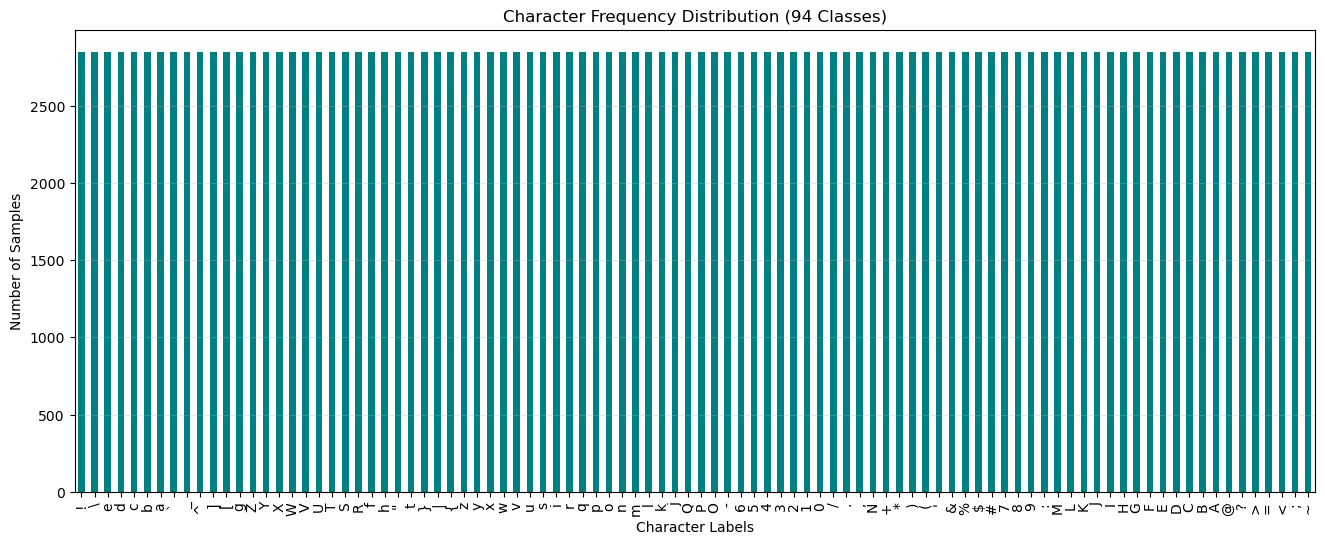

In [10]:
# Get label counts and unique values
label_counts = balanced_df['labels'].value_counts()
unique_labels = balanced_df['labels'].nunique()

plt.figure(figsize=(16, 6))
label_counts.plot(kind='bar', color='teal')
plt.title("Character Frequency Distribution (94 Classes)")
plt.xlabel("Character Labels")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.show()

The bar chart now shows a perfectly balanced distribution, with all classes having exactly the same number of samples (2,848).

## Examining the Balanced Dataset

In [11]:
balanced_df

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Maitree-Bold,!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Livvic-Italic,!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EricaOne-Regular,!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,UnifrakturCook-Bold,!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,UnifrakturMaguntia-Book,!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267707,RedHatDisplay-Italic[wght],~,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267708,Merienda-Bold,~,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267709,GildaDisplay-Regular,~,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267710,BigShouldersStencilText-Medium,~,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This output shows our balanced dataset with 267,712 rows and 786 columns. Each character class now has an equal representation, which should lead to better model training outcomes.

## Saving the Balanced Dataset

Finally, let's save our balanced dataset to a file for future use:

In [12]:
balanced_df.to_csv("../Data/balanced_94_character_TMNIST.csv", index=False)

print("Balanced dataset saved as 'balanced_94_character_TMNIST.csv'")

Balanced dataset saved as 'balanced_94_character_TMNIST.csv'


The balanced dataset has been successfully saved to a CSV file. This file can now be used for training machine learning models without the bias that would be introduced by class imbalance.

## Conclusion
In this notebook, we've:

1. Explored the 94 character TMNIST dataset and identified class imbalance issues
2. Visualized examples of characters from the dataset to understand its content
3. Used multiprocessing to efficiently balance the dataset by sampling an equal number of examples from each class
4. Created a perfectly balanced dataset with 2,848 samples for each of the 94 character classes
5. Saved the balanced dataset for future use in model training

This balanced dataset will be valuable for training machine learning models for character recognition that perform well across all character classes.